In [13]:
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob
import os
from datetime import datetime
from skimage.restoration import denoise_nl_means, denoise_wavelet
from skimage.exposure import equalize_hist, equalize_adapthist
from skimage import exposure, filters
from scipy import ndimage

In [14]:
input_dir = "Raw_Image_folders\AR11158_2011_02_13_1728_aia.euv_12m_94"

In [15]:
def get_file_details(path):
  filename = os.path.basename(path)
  list_filename = filename.split(sep = '_')
  Flarefile = list_filename[0]

  TYPE = list_filename[5].split(sep = '.')
  typef = ' '.join([str.upper(i) for i in TYPE]) + ' ' + list_filename[-1].split(sep = '.')[0] + "A"

  return Flarefile , typef


In [16]:
Flaredetails = get_file_details(input_dir)
Flaredetails

('AR11158', 'AIA EUV 94A')

In [17]:
filenames = glob(input_dir + "/*.fits")
filenames1 = sorted(filenames)

In [21]:
def extract_time(files , index):
  filename = os.path.basename(files[index])
  time_string = filename.split(sep = '.')[2]
  datetime_obj = datetime.strptime(time_string, "%Y-%m-%dT%H%M%SZ")
  # Format the combined date and time
  timestamps = datetime_obj.strftime("%Y-%m-%d %H:%M:%S")
  return timestamps

In [23]:
timestamps = []
for i in range(0, len(filenames1)):
  ts = extract_time(filenames1, i)
  timestamps.append(ts)
timestamps[100]

'2011-02-13 13:28:04'

In [24]:
# Read the data from each FITS file
images = [fits.getdata(file) for file in filenames1]

In [25]:
len(images)

153

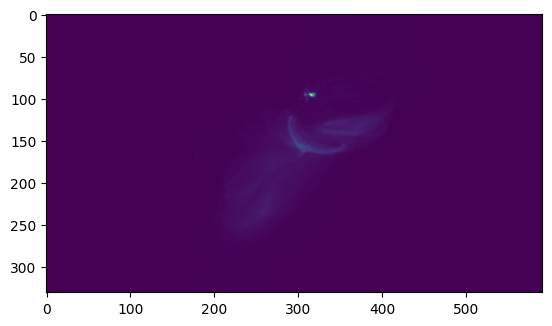

In [26]:
eg_img = images[130]
eg_img = eg_img[::-1, :]
plt.imshow(eg_img)

In [27]:
np.mean(images[100])

22.717386

In [28]:
def filter_images_by_intensity(images, intensity_threshold=1300):
    cleaned_files = []
    for image in images:
      # Check if any pixel intensity exceeds the threshold
      if np.mean(image) <= intensity_threshold:
          cleaned_files.append(image)

    return cleaned_files

cleaned = filter_images_by_intensity(images)

In [29]:
len(cleaned)

153

In [31]:
def fix_image_flashes(image):
  normalized_data = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
  image = normalized_data.astype(np.uint8)
  denoised = cv2.fastNlMeansDenoising(image, None, 3, 3, 21)

  thresh = cv2.threshold(denoised, 180, 255, cv2.THRESH_BINARY)[1]

  # Find the contours of the glare
  contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]

  # Create a mask of the glare
  mask = np.zeros(image.shape[:2], np.uint8)
  cv2.drawContours(mask, contours, -1, 255, -1)

  # Inpaint the glare
  inpainted_image = cv2.inpaint(image, mask, 3, cv2.INPAINT_TELEA)

  return inpainted_image

In [32]:
from skimage import exposure, filters

def enhance_image(image):
  image = image.astype(np.uint8)
  normalized_data = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
  equalized_data = exposure.equalize_adapthist(normalized_data) #adaptive histogran thresholding
  filtered_data = filters.median(equalized_data)
  sharpened_data = filters.unsharp_mask(filtered_data, radius=1, amount=2)
  threshold = filters.threshold_otsu(equalized_data) #thresholding with otsu
  binary_data = sharpened_data > threshold

  return binary_data #Final binary mask

def threshold(pixel):
    if pixel < 10:
        return 0
    else:
        return pixel

def filtered_image(image):
  normalized_data = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
  image = normalized_data.astype(np.uint8)
  kernel = np.ones((1,1),np.uint8)
  opening = cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)
  filtered_img = ndimage.generic_filter(opening, threshold, size=1)
  return filtered_img

def denoise(image):
  #normalized_data = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)
  #image = image.astype(np.uint8)
  denoised = cv2.fastNlMeansDenoising(image, None, 3, 3, 21)
  return denoised


def final_image(image):
  return enhance_image(image) + filtered_image(image)

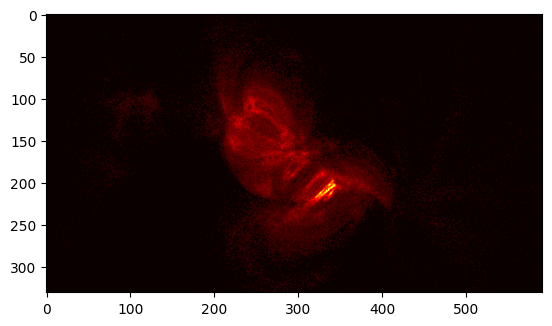

In [35]:
plt.imshow(final_image(images[10]), cmap = 'hot')

In [37]:
enhanced_list = [img[::-1, :] for img in cleaned]

In [38]:
enhanced_list = [final_image(i) for i in enhanced_list]

MovieWriter ffmpeg unavailable; using Pillow instead.


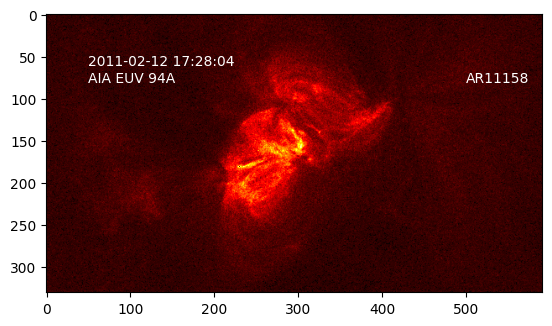

In [45]:
import matplotlib.animation as animation
%matplotlib inline
fig, ax = plt.subplots()

ax.set_xlim([0, enhanced_list[0].shape[0]])
ax.set_ylim([0, enhanced_list[0].shape[1]])

# Add labels to the axes
ax.set_xlabel("E-W (arcsec)")
ax.set_ylabel("S-N (arcsec)")

ax.set_aspect("equal")

# Create an animation function
def update(num, images, texts, flare_info, type_flare, ax):
    # Clear the current axes
    ax.clear()

    # Display the image
    ax.imshow(enhanced_list[num], cmap='hot')

    # Add text
    ax.text(50, 80, texts[num] + "\n" + type_flare, color='white')
    ax.text(500, 80, flare_info, color='white')

# Create an animation object
anim = animation.FuncAnimation(fig, update, interval=100, frames = len(enhanced_list), fargs = [enhanced_list, timestamps, Flaredetails[0], Flaredetails[1], ax])

# Save the animation as a video
anim.save("space_images.gif", bitrate = 2000)

In [47]:
from IPython.display import Image
from base64 import b64encode

def show_video(video_path):

  video_file = open(video_path, "r+b").read()

  video_url = f"data:video/gif;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video controls><source src="{video_url}"></video>""")

show_video("space_images.gif")
